In [77]:
import yaml
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy import units as u
from gammapy.utils.fitting import Parameter, Parameters
from gammapy.stats import wstat
from gammapy.spectrum import SpectrumFit, CrabSpectrum
from gammapy.spectrum.models import SpectralModel
from scipy import stats
from tqdm import tqdm

import corner

from gammapy.spectrum import CountsPredictor

import emcee

from utils import load_spectrum_observations, Log10Parabola

from scipy.stats import poisson
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy.optimize import minimize
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [18]:
tels = ['fact', 'magic', 'fermi', 'hess', 'veritas']

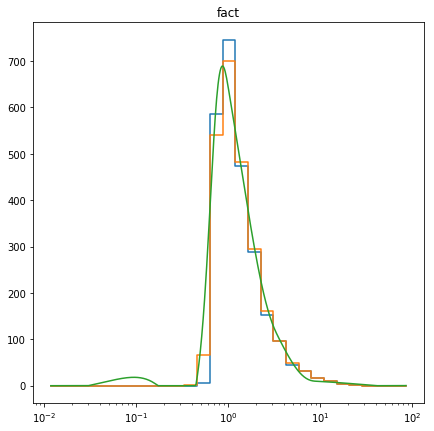

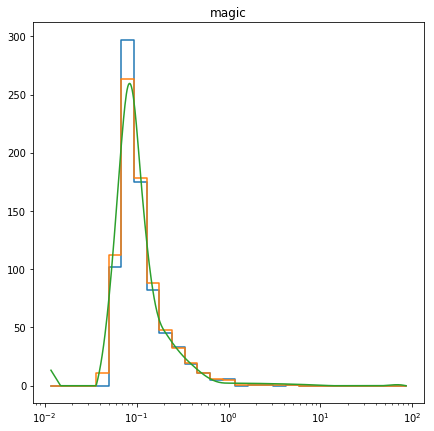

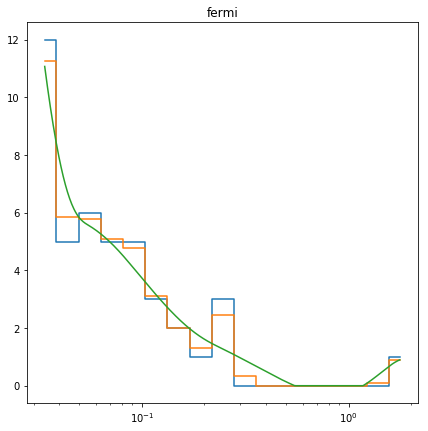

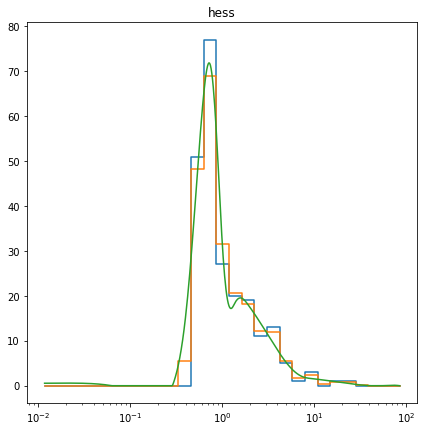

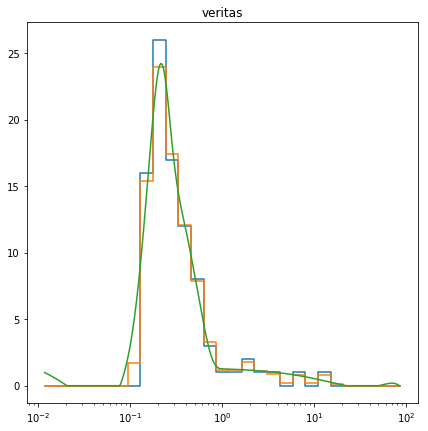

In [76]:
for tel in tels: 
    off_data = load_spectrum_observations(tel)[0].off_vector

    x = off_data.energy.log_center().to('TeV').value
    y = off_data.data.data
    plt.figure(figsize=(7, 7))
    plt.step(x, y, where='mid')
    plt.step(x, gaussian_filter1d(y, sigma=0.5), where='mid')


    f = interpolate.UnivariateSpline(x, y, s=y.var())
    
    N = 500
    s = np.logspace(np.log10(x.min()), np.log10(x.max()), N)
    v = f(s)
    
    plt.title(tel)
    plt.plot(s, np.where(v < 0, 0, v))
    plt.xscale('log')


In [39]:
def model_signal_prediction(model, observation):
    predictor = CountsPredictor(model=model, aeff=observation.aeff, edisp=observation.edisp, livetime=observation.livetime)
    predictor.run()
    counts = predictor.npred.data.data
    counts *= observation.on_vector.areascal
    return counts.value

def background_prediction(observation):
    x = observation.off_vector.energy.log_center().to('TeV').value
    y = observation.off_vector.data.data
    f = interpolate.UnivariateSpline(x, y, s=y.var())
    return f(x)


def ln_likelihood(theta, n_on, n_off, alpha):
    mu_sig, mu_bkg = theta
    with np.errstate(divide='ignore', invalid='ignore'):
        a = n_on * np.log(mu_sig + alpha*mu_bkg)
        b = n_off * np.log(mu_bkg)
    return -(a + b - mu_sig - (alpha + 1)*mu_bkg)
    

def ln_prior(theta, alpha):
    '''
    Uninformative poisson prior as far as I know. 
    
    See https://en.wikipedia.org/wiki/Jeffreys_prior
    '''
    mu_sig, mu_bkg = theta
    with np.errstate(divide='ignore', invalid='ignore'):
        m = np.log(np.sqrt(alpha) / np.sqrt(mu_bkg * (alpha*mu_bkg + mu_sig)))
        m[mu_sig < 0] = -np.inf
        m[mu_bkg < 0] = -np.inf

    return m


def ln_prob(theta, n_on, n_off, alpha, return_posterior=False):
    
    prob = ln_likelihood(theta, n_on, n_off, alpha)

    if return_posterior:
        lp = ln_prior(theta, alpha)
        prob = prob + lp
    
    return np.where(np.isfinite(prob), prob, 0)



def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]
        

def model_probability(theta, observations, return_posterior=False, fit_range=None):
    amplitude, alpha, beta = theta[0:3]
    normalizations = theta[3:]
    model = Log10Parabola(
        amplitude=amplitude * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
    
    obs_probabilities = []
    for obs, normalization in zip(observations, normalizations):
        mu_sig = model_signal_prediction(model, obs)
        n_on=obs.on_vector.data.data.value
        n_off=obs.off_vector.data.data.value
        obs_alpha=obs.alpha
        mu_bkg = normalization * background_prediction(obs)
        
        
        
        if fit_range is not None:
            bins = obs.on_vector.energy.bins
            mu_sig, n_on, n_off, obs_alpha, mu_bkg = apply_range(mu_sig, n_on, n_off, obs_alpha, mu_bkg, bins=bins, fit_range=fit_range)

        prob = ln_prob((mu_sig, mu_bkg), n_on, n_off, obs_alpha, return_posterior=return_posterior).sum()            

        obs_probabilities.append(prob)
    return -sum(obs_probabilities)
    

In [40]:
obs_list = load_spectrum_observations('magic')
fit_range = [0.08, 30] * u.TeV

In [41]:
theta = np.append([3.8, 2.3, 0.4], np.ones(len(obs_list)))
model_probability(theta, obs_list, return_posterior=False), model_probability(theta, obs_list, return_posterior=True)

(8147.1801147114, 8266.881324907163)

In [46]:
N = 25
betas = np.linspace(0, 0.8, N)
alphas = np.linspace(2.1, 2.8, N)
a, b = np.meshgrid(alphas, betas)

zs = []
zs_post = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
#     t1 = [3.8, alpha, beta]
#     tb = np.random.poisson(obs.background_vector.data.data.value.astype(np.int))
    theta = np.append([3.8, alpha, beta], np.ones(len(obs_list)))
    zs.append(model_probability(theta, obs_list, fit_range=fit_range))
    zs_post.append(model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range))

zs = np.array(zs)
zs_post = np.array(zs_post)


625it [00:10, 61.00it/s]


Text(0, 0.5, 'beta')

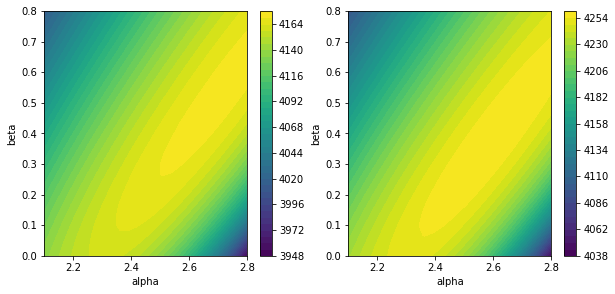

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

cf = ax1.contourf(a, b, zs.reshape(len(a), -1), levels=40)
# ax1.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

cf = ax2.contourf(a, b, zs_post.reshape(len(a), -1), levels=40)
plt.colorbar(cf, ax=ax2)
# ax2.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')


In [70]:
obs_list = load_spectrum_observations('joint')
fit_range = [0.08, 30] * u.TeV

theta = np.append([3.8, 2.3, 0.4], np.ones(len(obs_list)))
result = minimize(lambda *x: -model_probability(*x), x0=theta, args=(obs_list, True, fit_range))
result

      fun: -26634.531736559213
 hess_inv: array([[ 1.82898937e-02,  1.32181358e-03,  1.39149018e-03,
         1.37894023e-02, -2.65426500e-02, -6.68951319e-04,
         2.79254162e-03, -2.82177644e-05,  1.26006321e-02,
        -2.64142391e-04,  2.94591852e-03,  4.80857375e-04,
        -1.56245063e-02],
       [ 1.32181358e-03,  7.23898695e-04,  5.36160023e-04,
         1.28346169e-03, -2.27543348e-03, -9.54721101e-05,
         2.31875327e-04,  2.99019416e-05,  1.10475698e-03,
        -5.57963081e-06,  2.87856416e-04,  3.45018932e-06,
        -1.40680586e-03],
       [ 1.39149018e-03,  5.36160023e-04,  5.00717512e-04,
         1.25179670e-03, -2.40477227e-03, -6.79907985e-05,
         2.46799186e-04,  1.19105525e-04,  1.16382661e-03,
        -1.02414313e-05,  2.73842685e-04,  1.25235542e-05,
        -1.19544476e-03],
       [ 1.37894023e-02,  1.28346169e-03,  1.25179670e-03,
         1.48577729e-02, -2.08996657e-02, -4.97345163e-04,
         2.94444702e-04, -5.85590479e-05,  9.86706896e

In [71]:
ndim, nwalkers = len(result.x), 100
# print(ndim, nwalkers)
pos = np.array([result.x + 0.025 * np.random.randn(ndim) for i in range(nwalkers)])
# print(pos)
sampler = emcee.EnsembleSampler(nwalkers, ndim, model_probability, args=(obs_list, True, fit_range), threads=2)
sampler_output = sampler.run_mcmc(pos, 150, progress=True)

100%|██████████| 150/150 [07:32<00:00,  3.19s/it]


Number of params/dims: 13
shape of samples: (100, 150, 13)


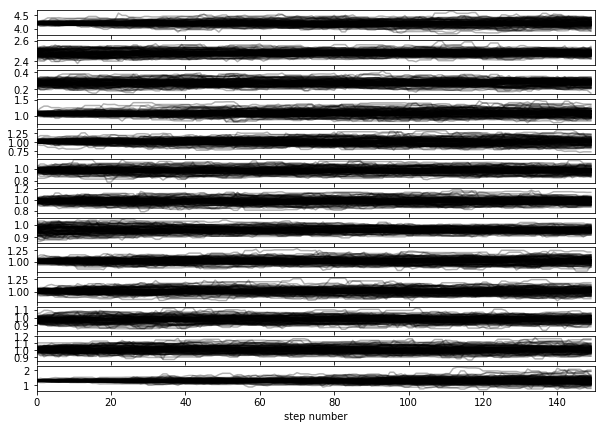

In [72]:
print(f'Number of params/dims: {ndim}')
print(f'shape of samples: {sampler.chain.shape}')
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
# labels = ["amplitude", "alpha", "beta"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i].T, "k", alpha=0.3)
    ax.set_xlim(0, len(sampler.chain[0]))
#     ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


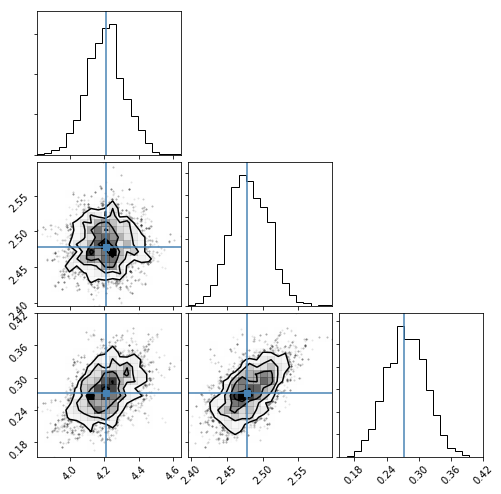

In [73]:
fig = corner.corner(sampler.chain[:, 50:, :3].reshape([-1, 3]), truths=result.x)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[4.21120644 2.48048766 0.27610022]


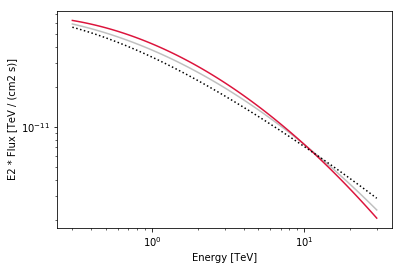

In [80]:
from IPython.display import display, Math

labels = ["amplitude", "alpha", "beta"]
for i in range(3):
    mcmc = np.percentile(sampler.chain[:, 50:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
joint_model = Log10Parabola(
    amplitude=3.78 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.49 * u.Unit(''),
    beta=0.22 * u.Unit(''),
)
joint_model.plot(energy_range=[0.3, 30]*u.TeV, energy_power=2, color='silver')

r = np.median(sampler.chain[:, 50:, :3], axis=(0, 1))
print(r)
fitted_model = Log10Parabola(
    amplitude=r[0] * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=r[1] * u.Unit(''),
    beta=r[2] * u.Unit(''),
)
fitted_model.plot(energy_range=[0.3, 30]*u.TeV, energy_power=2, color='crimson')

CrabSpectrum(reference='meyer').model.plot(energy_range=[0.3, 30]*u.TeV, energy_power=2, color='black', ls=':')

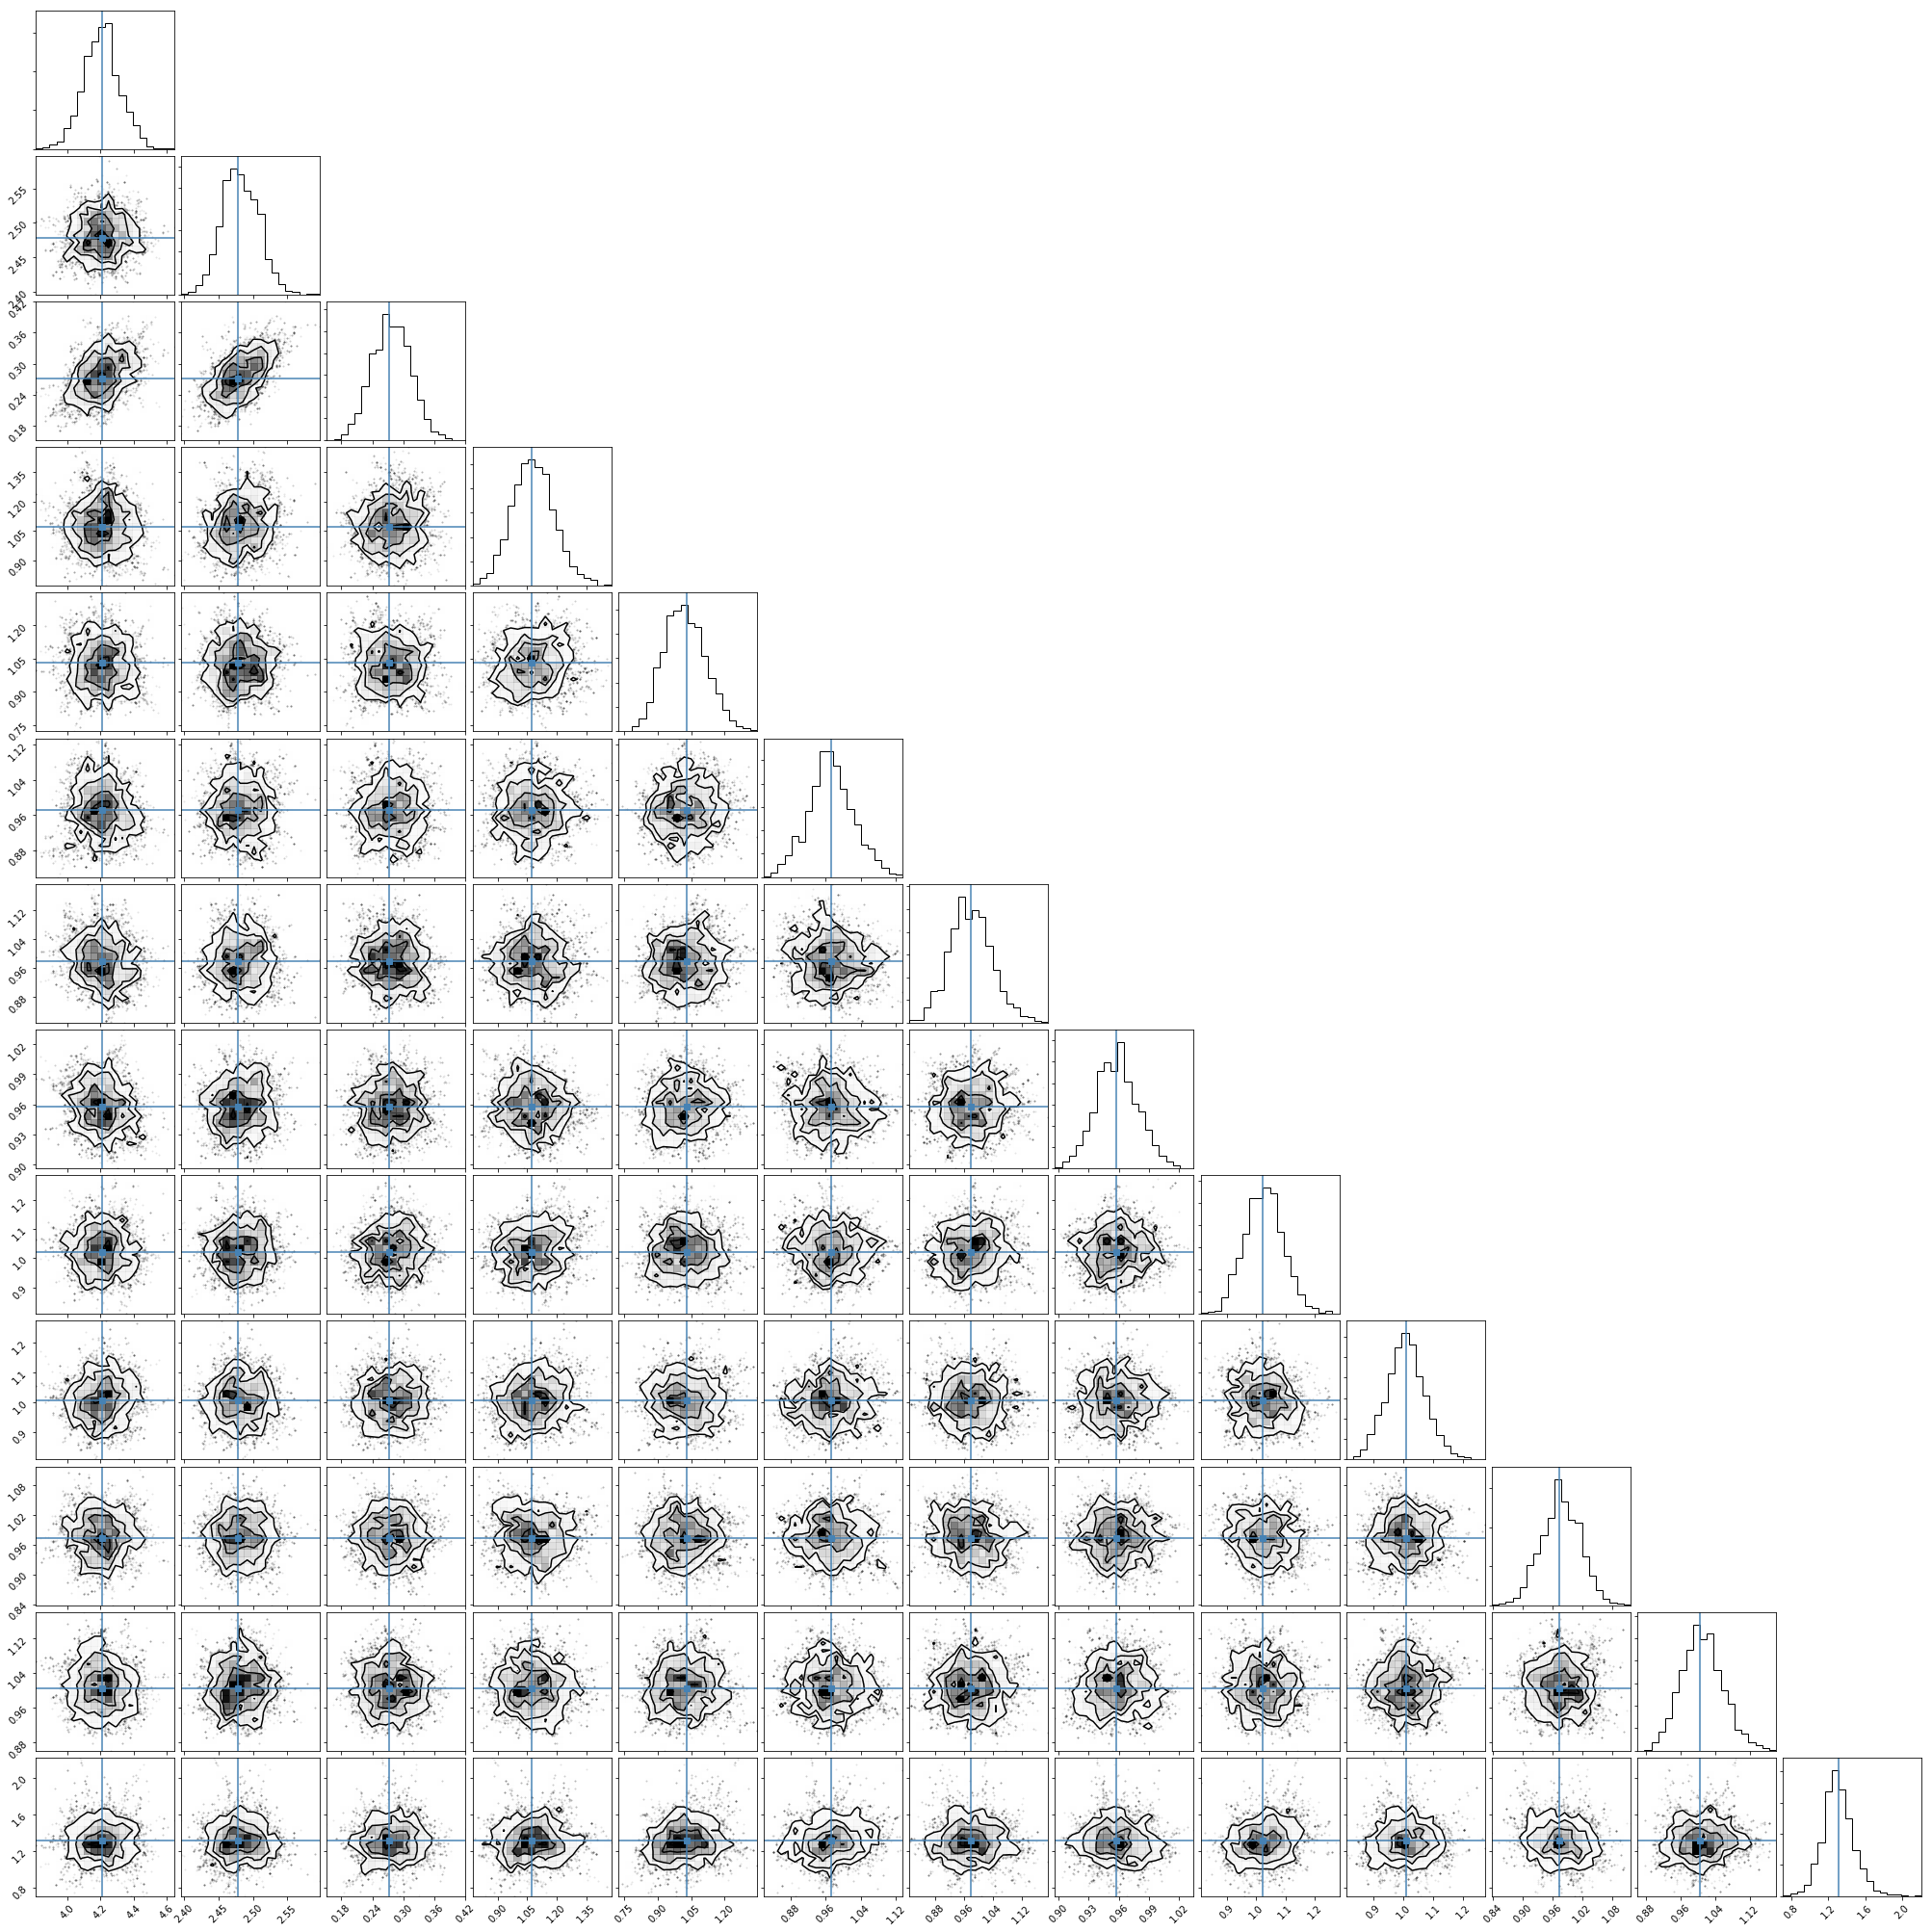

In [75]:
# fig = corner.corner(sampler.chain[:, 50:, :].reshape([-1, ndim]), truths=result.x)